In [1]:
import pandas as pd
import os

# Check files in current folder
print("Files in folder:", os.listdir())

# Load datasets
df1 = pd.read_csv("datafile.csv")
df2 = pd.read_csv("datafile (1).csv")
df3 = pd.read_csv("datafile (2).csv")
df4 = pd.read_csv("datafile (3).csv")
df5 = pd.read_csv("produce.csv")

# Print column names of each to check
print("\n--- df1 ---\n", df1.columns)
print("\n--- df2 ---\n", df2.columns)
print("\n--- df3 ---\n", df3.columns)
print("\n--- df4 ---\n", df4.columns)
print("\n--- df5 ---\n", df5.columns)

# Later we will clean & merge, but first let’s just confirm columns are read correctly


Files in folder: ['.venv', 'datafile (1).csv', 'datafile (2).csv', 'datafile (3).csv', 'datafile.csv', 'model.ipynb', 'produce.csv']

--- df1 ---
 Index(['Crop', '2004-05', '2005-06', '2006-07', '2007-08', '2008-09',
       '2009-10', '2010-11', '2011-12'],
      dtype='object')

--- df2 ---
 Index(['Crop', 'State', 'Cost of Cultivation (`/Hectare) A2+FL',
       'Cost of Cultivation (`/Hectare) C2',
       'Cost of Production (`/Quintal) C2', 'Yield (Quintal/ Hectare) '],
      dtype='object')

--- df3 ---
 Index(['Crop             ', 'Production 2006-07', 'Production 2007-08',
       'Production 2008-09', 'Production 2009-10', 'Production 2010-11',
       'Area 2006-07', 'Area 2007-08', 'Area 2008-09', 'Area 2009-10',
       'Area 2010-11', 'Yield 2006-07', 'Yield 2007-08', 'Yield 2008-09',
       'Yield 2009-10', 'Yield 2010-11'],
      dtype='object')

--- df4 ---
 Index(['Crop', 'Variety', 'Season/ duration in days', 'Recommended Zone',
       'Unnamed: 4'],
      dtype='object')


#create one dataset

In [ ]:
# --- Step 1: Clean column names ---
df1.columns = df1.columns.str.strip()
df2.columns = df2.columns.str.strip()
df3.columns = df3.columns.str.strip()
df4.columns = df4.columns.str.strip()
df5.columns = df5.columns.str.strip()

# Fix inconsistent crop column names
df3 = df3.rename(columns={"Crop             ": "Crop"})
df5 = df5.rename(columns={"Particulars": "Crop"})

# --- Step 2: Reshape (df1) ---
df1_long = df1.melt(id_vars=["Crop"], var_name="Year", value_name="Production")
df1_long["Year"] = df1_long["Year"].str.extract(r'(\d{4})').astype(int)

# --- Step 3: Reshape (df3) ---
df3_prod = df3.melt(id_vars=["Crop"], 
                    value_vars=[c for c in df3.columns if "Production" in c], 
                    var_name="Year", value_name="Production")
df3_prod["Year"] = df3_prod["Year"].str.extract(r'(\d{4})').astype(int)

df3_area = df3.melt(id_vars=["Crop"], 
                    value_vars=[c for c in df3.columns if "Area" in c], 
                    var_name="Year", value_name="Area")
df3_area["Year"] = df3_area["Year"].str.extract(r'(\d{4})').astype(int)

df3_yield = df3.melt(id_vars=["Crop"], 
                     value_vars=[c for c in df3.columns if "Yield" in c], 
                     var_name="Year", value_name="Yield")
df3_yield["Year"] = df3_yield["Year"].str.extract(r'(\d{4})').astype(int)

df3_long = df3_prod.merge(df3_area, on=["Crop","Year"], how="outer") \
                   .merge(df3_yield, on=["Crop","Year"], how="outer")

# --- Step 4: Reshape (df5) ---
df5_long = df5.melt(id_vars=["Crop","Frequency","Unit"], 
                    var_name="Year", value_name="Value")
df5_long["Year"] = df5_long["Year"].str.extract(r'(\d{4})').astype(int)

# --- Step 5: Merge all datasets ---
# Start from df1 (2004–2012 production base)
master = df1_long.merge(df3_long, on=["Crop","Year"], how="outer")
master = master.merge(df2, on="Crop", how="left")   # cost/yield/state
master = master.merge(df4.drop(columns=["Unnamed: 4"]), on="Crop", how="left") # variety, season
master = master.merge(df5_long, on=["Crop","Year"], how="outer")

# --- Step 6: Save final dataset ---
master.to_csv("master_agriculture_dataset.csv", index=False)

print("Master dataset created: master_agriculture_dataset.csv")
print(master.head(20))


✅ Master dataset created: master_agriculture_dataset.csv
                                          Crop  Year  Production_x  \
0   (DC)Agricultural Coverage Under Irrigation  1993           NaN   
1   (DC)Agricultural Coverage Under Irrigation  1994           NaN   
2   (DC)Agricultural Coverage Under Irrigation  1995           NaN   
3   (DC)Agricultural Coverage Under Irrigation  1996           NaN   
4   (DC)Agricultural Coverage Under Irrigation  1997           NaN   
5   (DC)Agricultural Coverage Under Irrigation  1998           NaN   
6   (DC)Agricultural Coverage Under Irrigation  1999           NaN   
7   (DC)Agricultural Coverage Under Irrigation  2000           NaN   
8   (DC)Agricultural Coverage Under Irrigation  2001           NaN   
9   (DC)Agricultural Coverage Under Irrigation  2002           NaN   
10  (DC)Agricultural Coverage Under Irrigation  2003           NaN   
11  (DC)Agricultural Coverage Under Irrigation  2004           NaN   
12  (DC)Agricultural Coverage Und

remove macro indicators

In [4]:
# Ensure Crop column is string
master["Crop"] = master["Crop"].astype(str)

# Filter: remove rows where Crop starts with "(DC)"
master_clean = master[~master["Crop"].str.startswith("(DC)")].copy()

# Save cleaned dataset
master_clean.to_csv("master_agriculture_dataset_clean.csv", index=False)

print(" Cleaned dataset saved as master_agriculture_dataset_clean.csv")


 Cleaned dataset saved as master_agriculture_dataset_clean.csv


In [6]:
import pandas as pd

df = pd.read_csv("master_agriculture_dataset_clean.csv")
df.head()
print(df.columns)


Index(['Crop', 'Year', 'Production_x', 'Production_y', 'Area', 'Yield',
       'State', 'Cost of Cultivation (`/Hectare) A2+FL',
       'Cost of Cultivation (`/Hectare) C2',
       'Cost of Production (`/Quintal) C2', 'Yield (Quintal/ Hectare)',
       'Variety', 'Season/ duration in days', 'Recommended Zone', 'Frequency',
       'Unit', 'Value'],
      dtype='object')


In [7]:
import pandas as pd

# 1. Load the cleaned master dataset
master = pd.read_csv("master_agriculture_dataset_clean.csv")

# 2. Standardize column names (remove spaces, unify naming)
master.columns = master.columns.str.strip().str.replace(" ", "_").str.replace("(", "").str.replace(")", "").str.replace("`", "")

# 3. Merge duplicate production columns if present
if "Production_x" in master.columns and "Production_y" in master.columns:
    master["Production"] = master["Production_x"].combine_first(master["Production_y"])
    master.drop(["Production_x", "Production_y"], axis=1, inplace=True)
elif "Production_x" in master.columns:
    master.rename(columns={"Production_x": "Production"}, inplace=True)
elif "Production_y" in master.columns:
    master.rename(columns={"Production_y": "Production"}, inplace=True)

# 4. Clean Year column (ensure numeric year)
master["Year"] = master["Year"].astype(str).str.extract(r"(\d{4})").astype(float)

# 5. Handle missing values
# Drop rows where Production (target) is missing
master = master.dropna(subset=["Production"])

# Fill numeric NaN with median
num_cols = master.select_dtypes(include=["float64", "int64"]).columns
master[num_cols] = master[num_cols].fillna(master[num_cols].median())

# Fill categorical NaN with "Unknown"
cat_cols = master.select_dtypes(include=["object"]).columns
master[cat_cols] = master[cat_cols].fillna("Unknown")

# 6. Save final model dataset
master.to_csv("agriculture_model_dataset.csv", index=False)

print("✅ Final dataset saved as agriculture_model_dataset.csv")
print("Shape:", master.shape)
print("Columns:", master.columns.tolist())


✅ Final dataset saved as agriculture_model_dataset.csv
Shape: (495, 16)
Columns: ['Crop', 'Year', 'Area', 'Yield', 'State', 'Cost_of_Cultivation_/Hectare_A2+FL', 'Cost_of_Cultivation_/Hectare_C2', 'Cost_of_Production_/Quintal_C2', 'Yield_Quintal/_Hectare', 'Variety', 'Season/_duration_in_days', 'Recommended_Zone', 'Frequency', 'Unit', 'Value', 'Production']


#Now work with this final dataset

##EDA

Dataset info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 495 entries, 0 to 494
Data columns (total 16 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Crop                                495 non-null    object 
 1   Year                                495 non-null    float64
 2   Area                                495 non-null    float64
 3   Yield                               495 non-null    float64
 4   State                               0 non-null      float64
 5   Cost_of_Cultivation_/Hectare_A2+FL  0 non-null      float64
 6   Cost_of_Cultivation_/Hectare_C2     0 non-null      float64
 7   Cost_of_Production_/Quintal_C2      0 non-null      float64
 8   Yield_Quintal/_Hectare              0 non-null      float64
 9   Variety                             495 non-null    object 
 10  Season/_duration_in_days            495 non-null    object 
 11  Recommended_Zone              

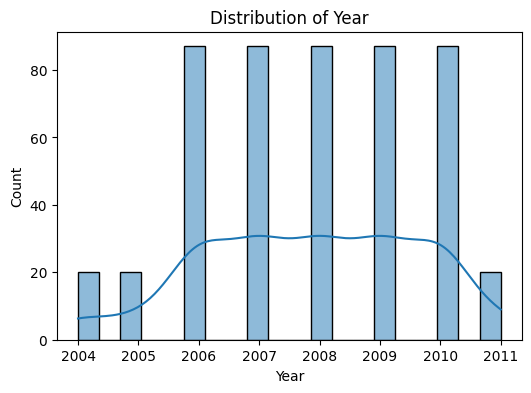

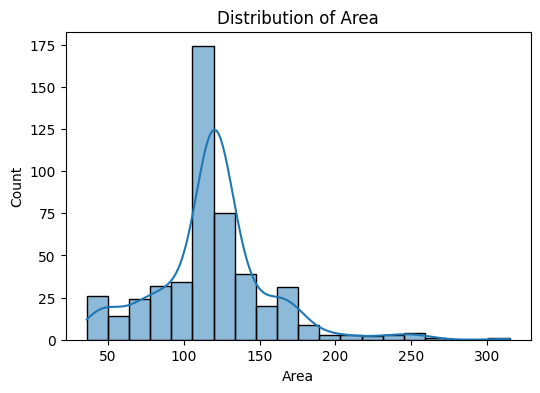

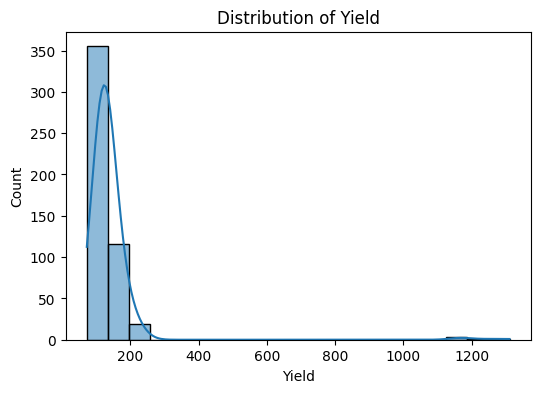

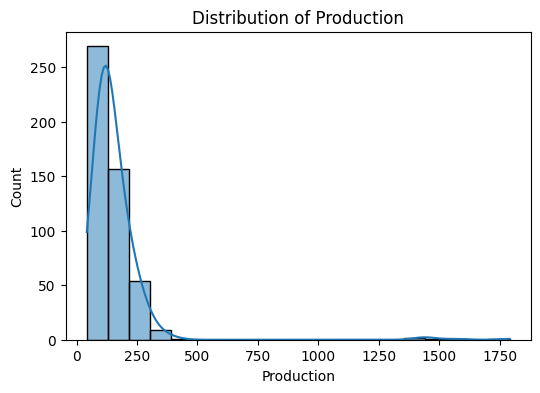

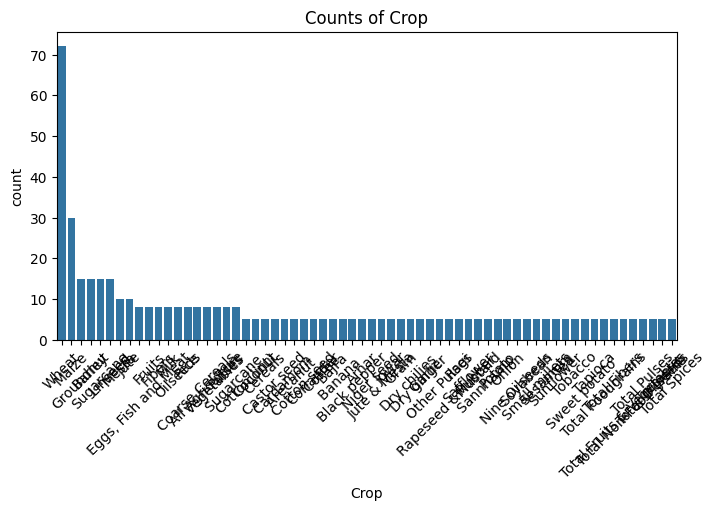

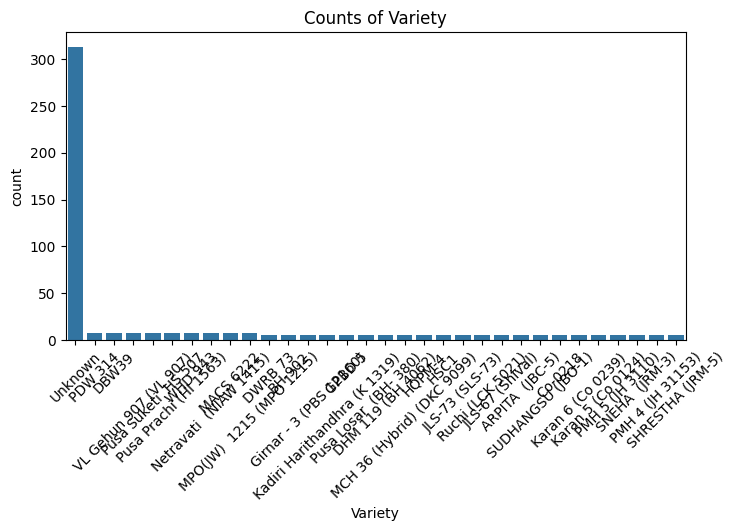

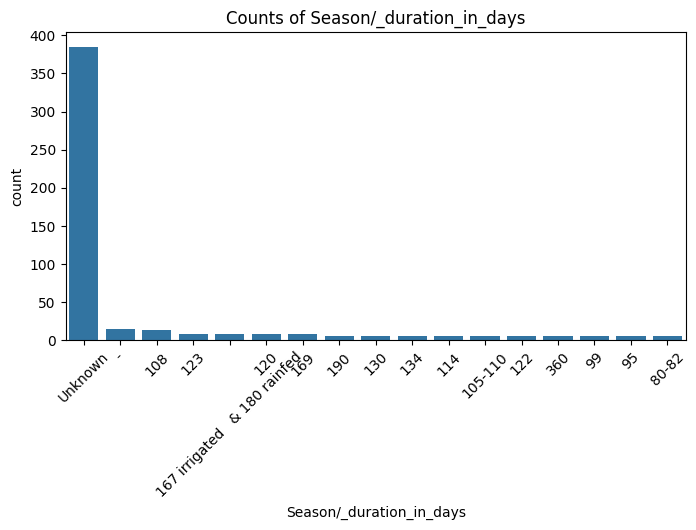

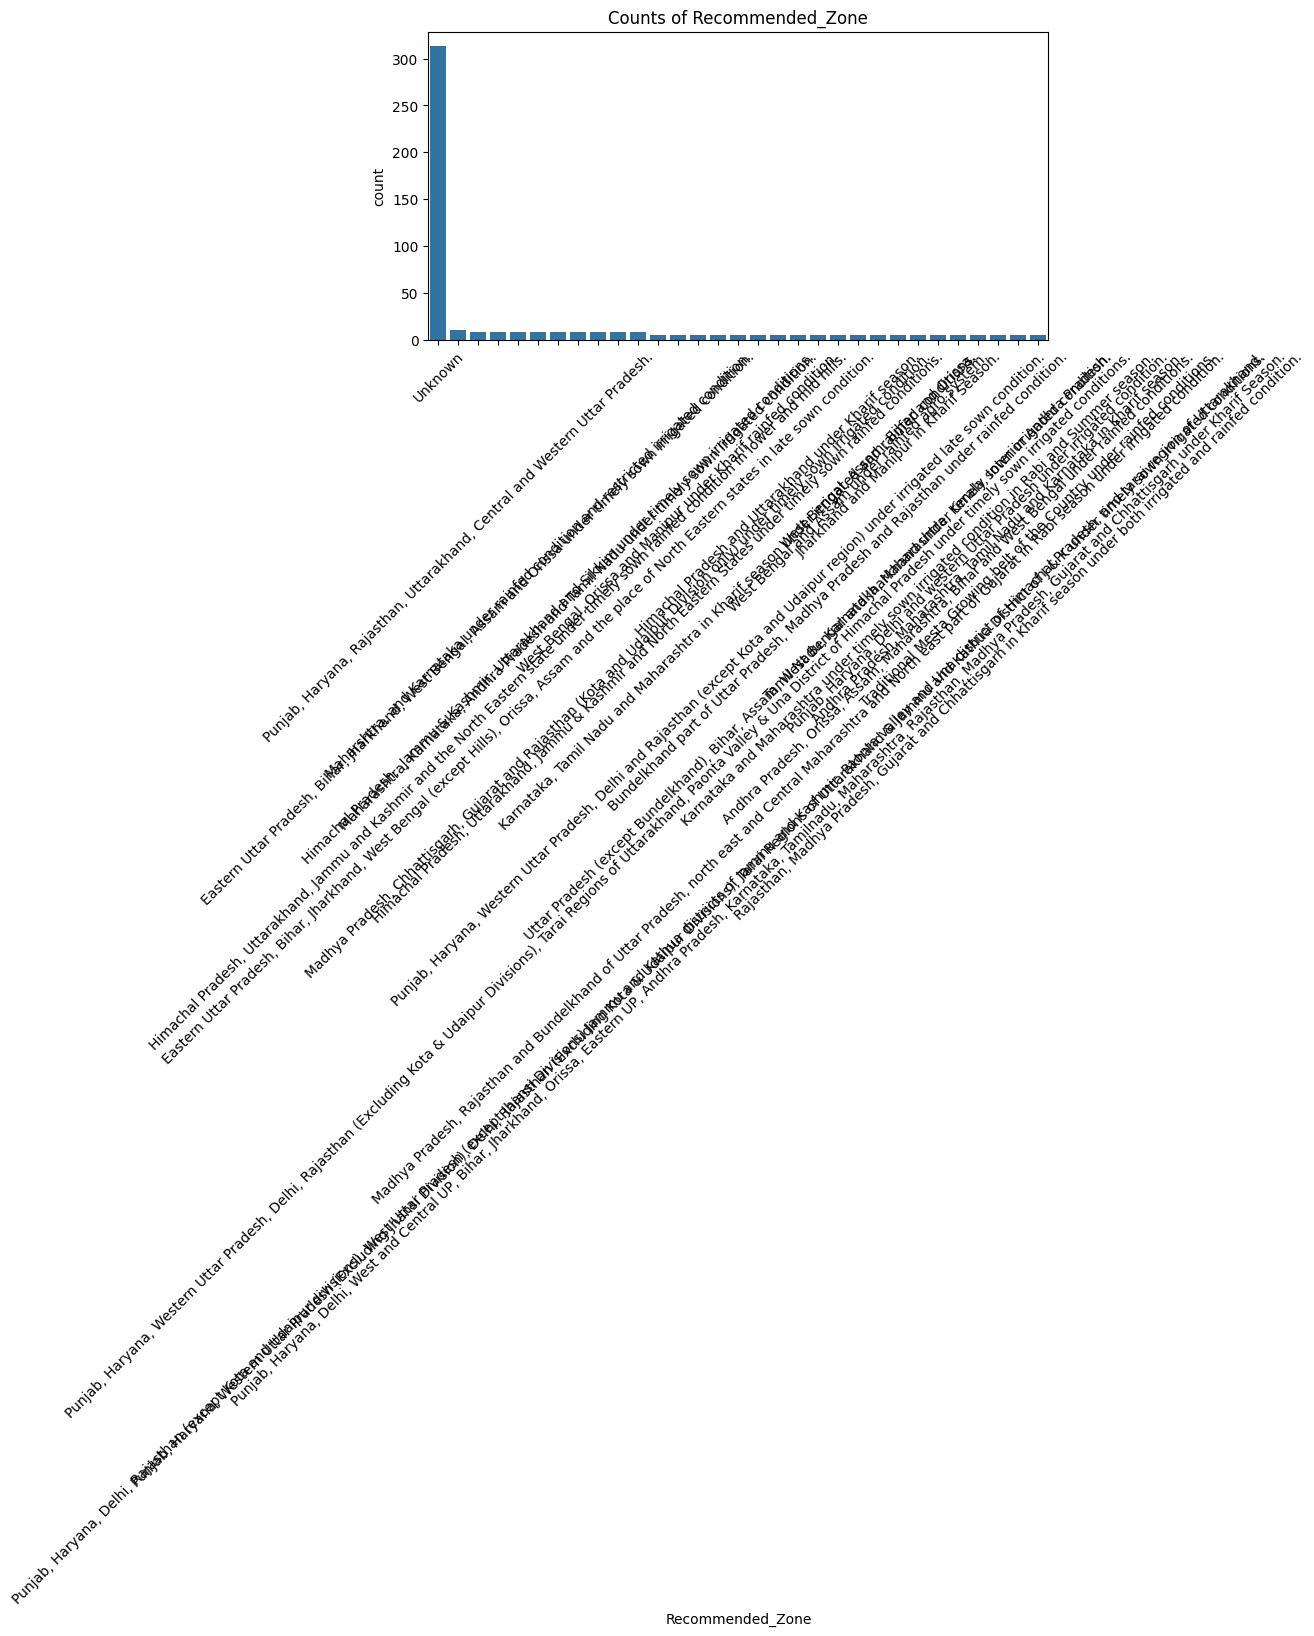

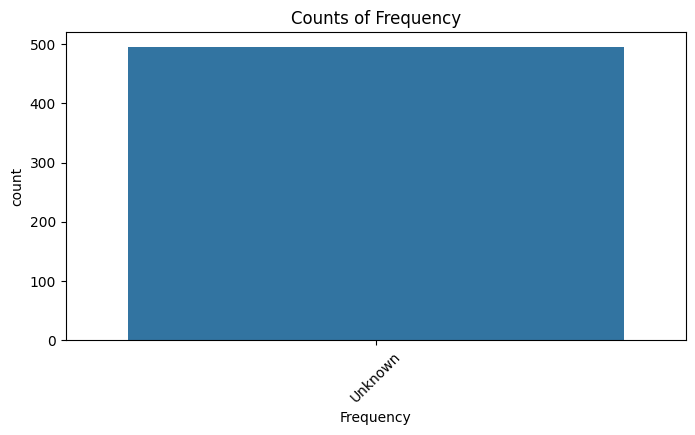

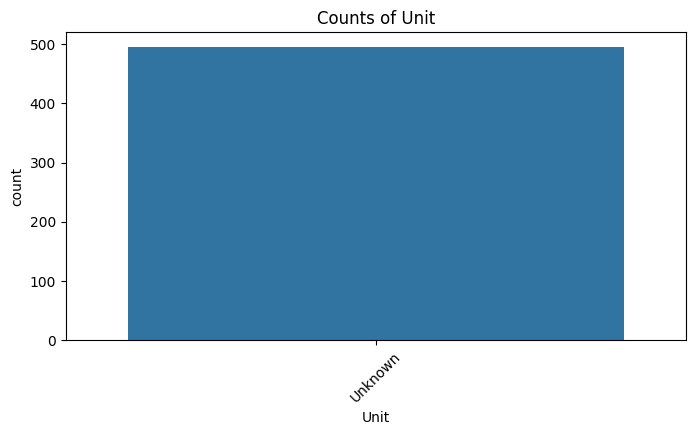

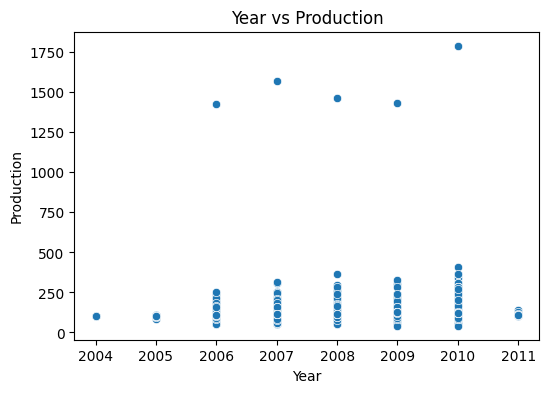

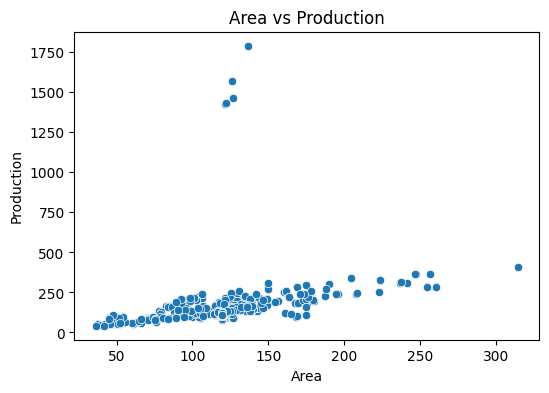

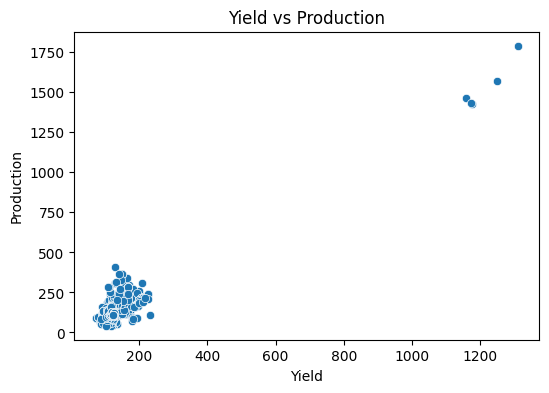

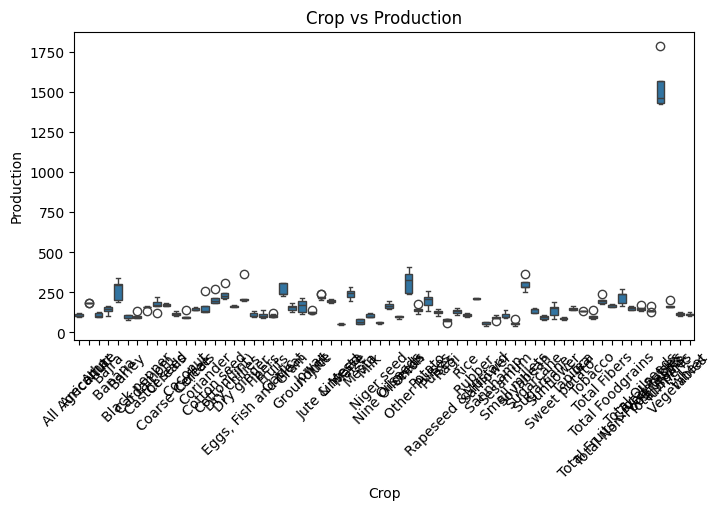

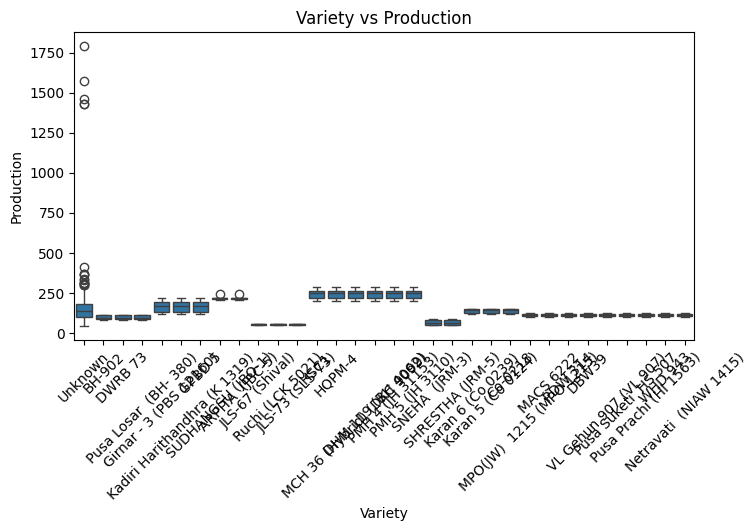

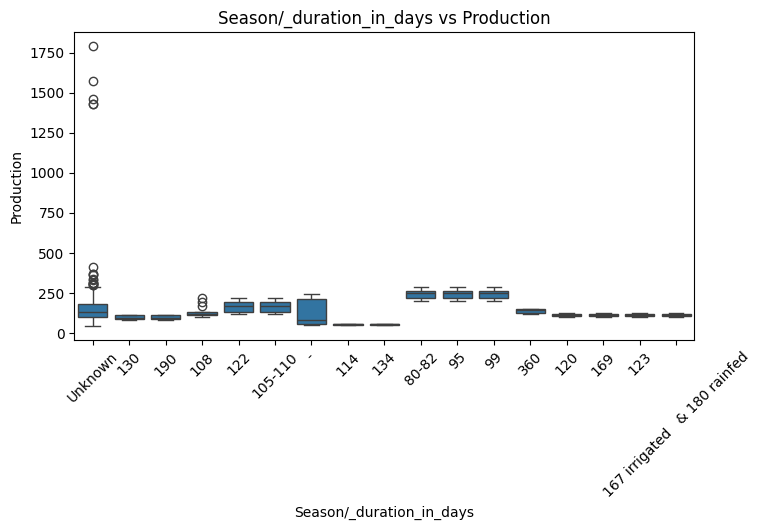

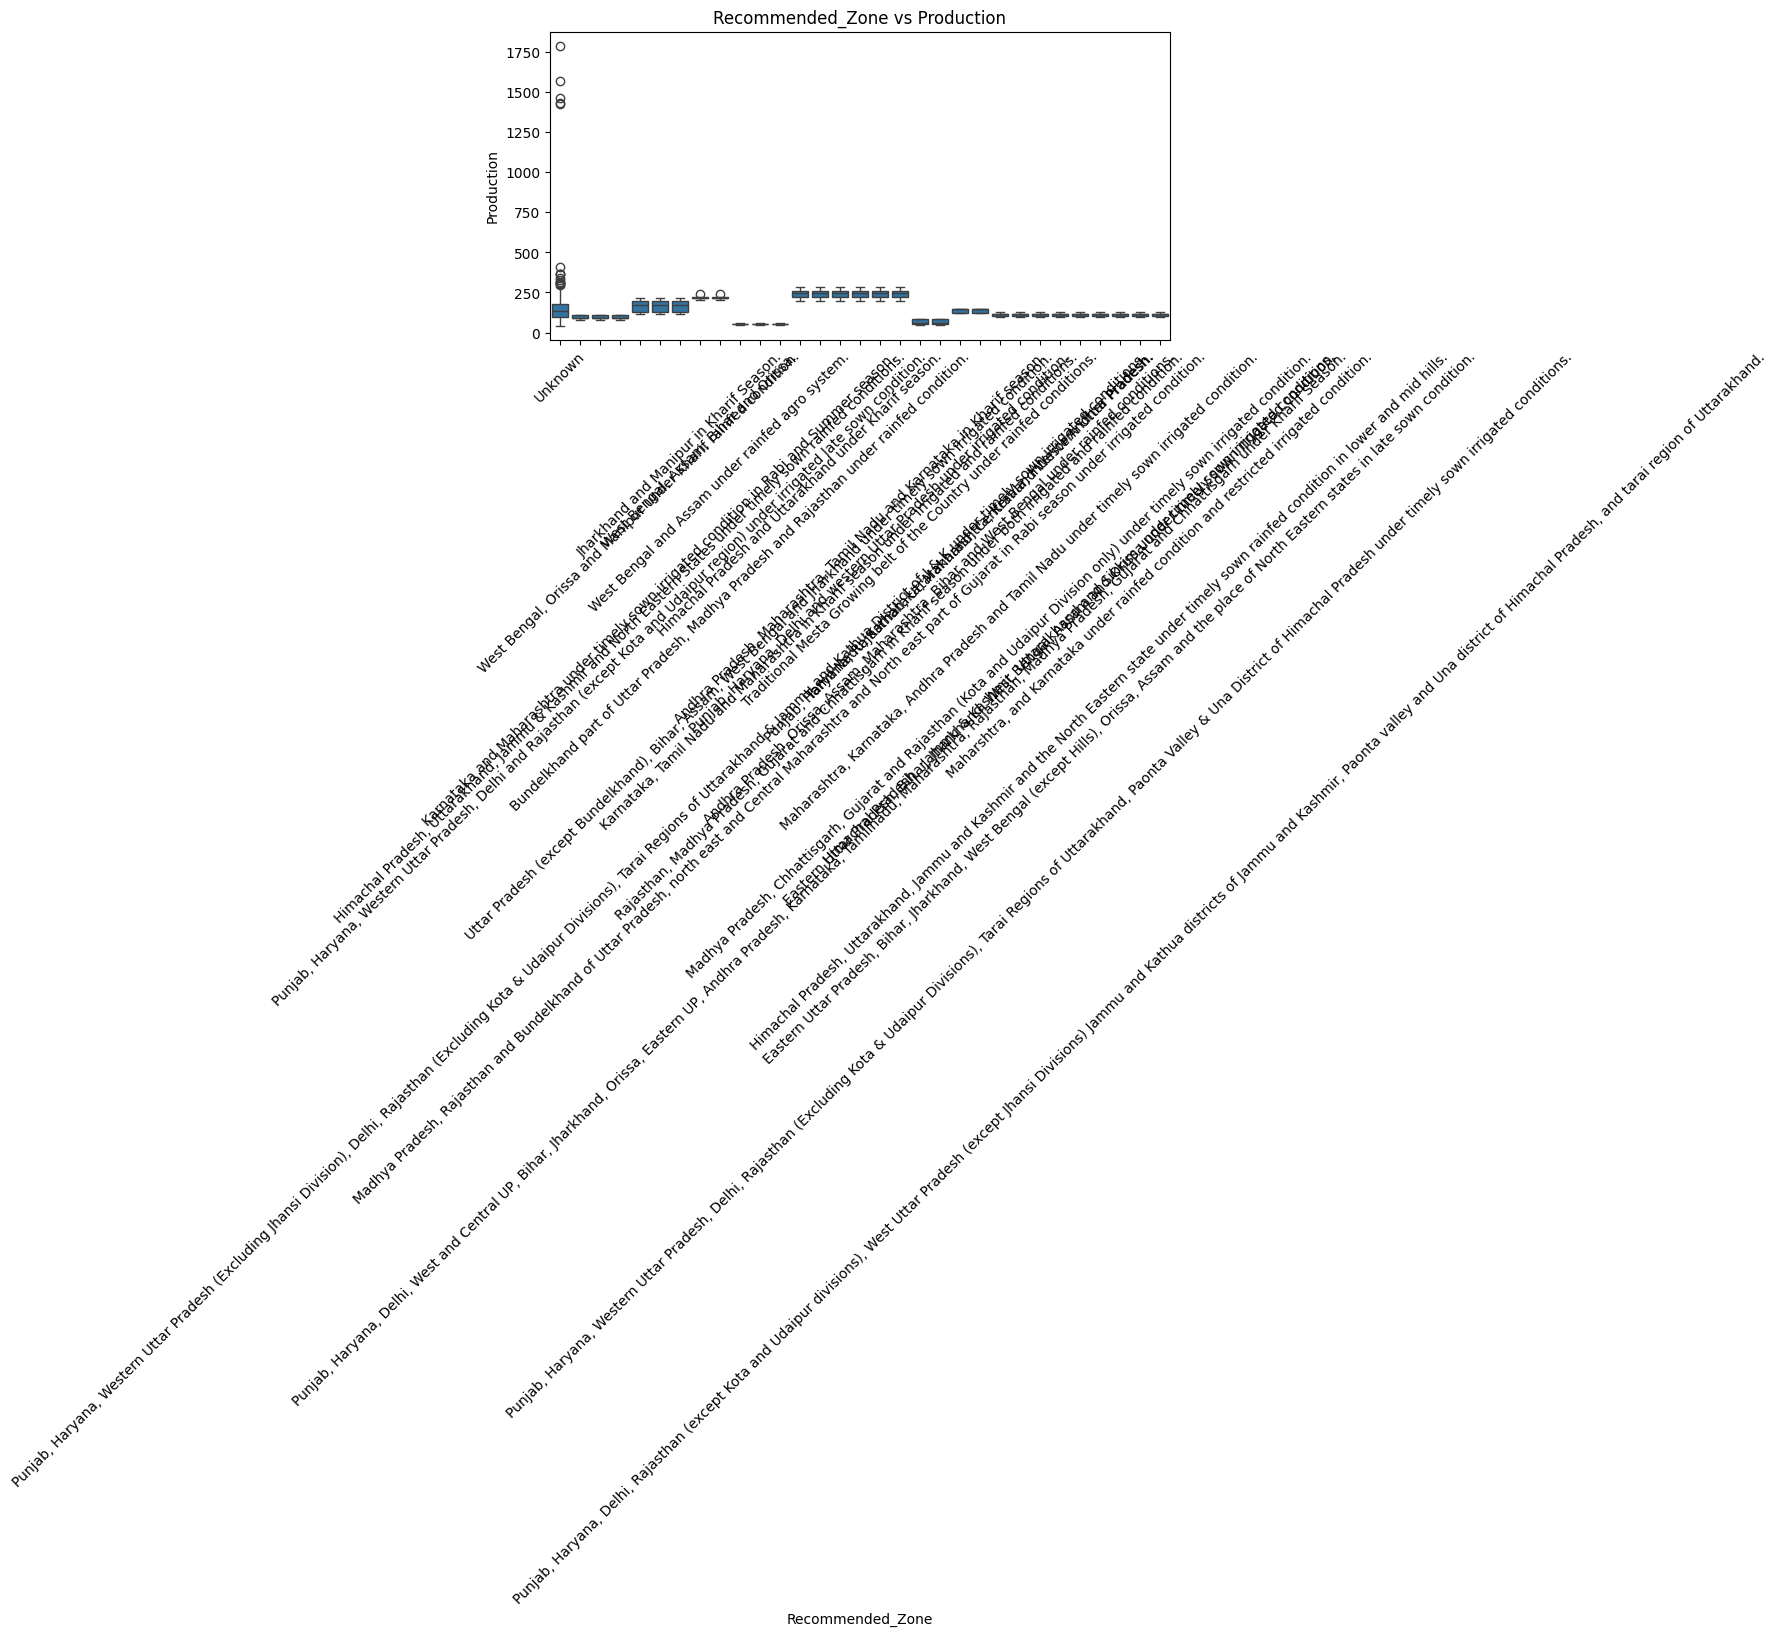

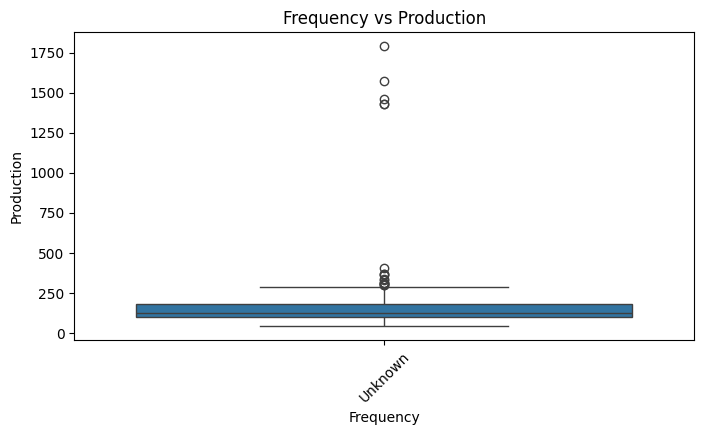

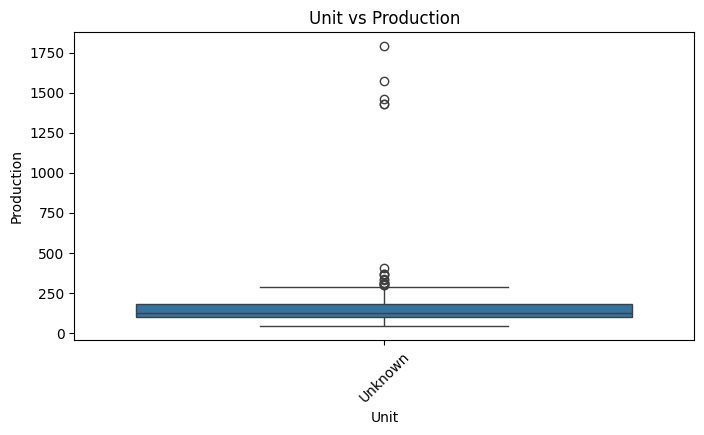

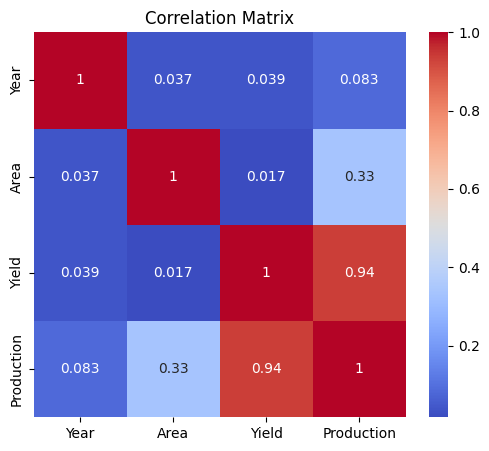

Year: 0 outliers
Area: 73 outliers
Yield: 49 outliers
Production: 17 outliers

Summary statistics for numeric features:
              Year        Area        Yield   Production
count   495.000000  495.000000   495.000000   495.000000
mean   2007.838384  118.911313   141.273333   156.554545
std       1.763939   37.711222   111.661707   153.117482
min    2004.000000   36.100000    72.700000    42.100000
25%    2006.000000  104.250000   116.950000   101.000000
50%    2008.000000  119.500000   123.900000   124.000000
75%    2009.000000  130.750000   138.900000   178.300000
max    2011.000000  314.700000  1310.800000  1790.600000


In [ ]:

# 1. Import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# 2. Load dataset

df = pd.read_csv("agriculture_model_dataset.csv")
print("Dataset info:\n")
print(df.info(), "\n")
print("First 5 rows:\n", df.head())


# 3. Missing values

print("\nMissing values per column:")
missing_counts = df.isnull().sum()
missing_percent = df.isnull().mean() * 100
missing_df = pd.DataFrame({'missing_count': missing_counts, 'missing_percent': missing_percent})
print(missing_df)


# 4. Drop columns with too many missing values (>50%)

drop_cols = df.columns[df.isnull().mean() > 0.5]
print("\nDropping columns with >50% missing values:", list(drop_cols))
df = df.drop(columns=drop_cols)


# 5. Identify categorical and numeric features

categorical_features = df.select_dtypes(include=["object"]).columns.tolist()
numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_features.remove("Production")  # target column

print("\nCategorical features:", categorical_features)
print("Numeric features:", numeric_features)


# 6. Explore numeric distributions

for col in numeric_features + ["Production"]:
    plt.figure(figsize=(6,4))
    sns.histplot(df[col], kde=True, bins=20)
    plt.title(f'Distribution of {col}')
    plt.show()


# 7. Explore categorical distributions

for col in categorical_features:
    plt.figure(figsize=(8,4))
    sns.countplot(data=df, x=col, order=df[col].value_counts().index)
    plt.xticks(rotation=45)
    plt.title(f'Counts of {col}')
    plt.show()


# 8. Numeric features vs target

for col in numeric_features:
    plt.figure(figsize=(6,4))
    sns.scatterplot(data=df, x=col, y='Production')
    plt.title(f'{col} vs Production')
    plt.show()


# 9. Categorical features vs target

for col in categorical_features:
    plt.figure(figsize=(8,4))
    sns.boxplot(data=df, x=col, y='Production')
    plt.xticks(rotation=45)
    plt.title(f'{col} vs Production')
    plt.show()


# 10. Correlation heatmap

plt.figure(figsize=(6,5))
corr = df[numeric_features + ["Production"]].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()


# 11. Outlier detection (IQR method)

for col in numeric_features + ["Production"]:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5*IQR
    upper = Q3 + 1.5*IQR
    outliers = df[(df[col] < lower) | (df[col] > upper)]
    print(f"{col}: {len(outliers)} outliers")


# 12. Summary statistics

print("\nSummary statistics for numeric features:")
print(df[numeric_features + ["Production"]].describe())


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, RobustScaler, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Load dataset

df = pd.read_csv("agriculture_model_dataset.csv")

# Drop columns with >50% missing values

drop_cols = df.columns[df.isnull().mean() > 0.5]
print("Dropping columns with too many missing values:", list(drop_cols))
df = df.drop(columns=drop_cols)

# Define features/target

target = "Production"
X = df.drop(columns=[target])
y = df[target]

categorical_features = X.select_dtypes(include=["object"]).columns.tolist()
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()

print("Categorical:", categorical_features)
print("Numeric:", numeric_features)

# Cap outliers at 1.5*IQR

def cap_outliers(df, cols):
    df = df.copy()
    for col in cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5*IQR
        upper = Q3 + 1.5*IQR
        df[col] = np.where(df[col] < lower, lower, df[col])
        df[col] = np.where(df[col] > upper, upper, df[col])
    return df[cols]  # Return only numeric columns

# Apply to numeric features
X[numeric_features] = cap_outliers(X, numeric_features)

# Cap y (target) directly
Q1 = y.quantile(0.25)
Q3 = y.quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5*IQR
upper = Q3 + 1.5*IQR
y = y.clip(lower, upper)

# Optional: log-transform skewed features

skewed_features = ['Yield']  
log_transformer = FunctionTransformer(np.log1p, validate=True)
for col in skewed_features:
    X[col] = log_transformer.transform(X[[col]])




# 1. Impute missing values
for col in numeric_features:
    X[col] = X[col].fillna(X[col].median())
for col in categorical_features:
    X[col] = X[col].fillna(X[col].mode()[0])

# 2. Scale numeric features
from sklearn.preprocessing import RobustScaler, OneHotEncoder
scaler = RobustScaler()
X[numeric_features] = scaler.fit_transform(X[numeric_features])

# 3. Encode categorical features
encoder = OneHotEncoder(handle_unknown="ignore", sparse=False)
encoded = encoder.fit_transform(X[categorical_features])
encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(categorical_features), index=X.index)
X = pd.concat([X.drop(columns=categorical_features), encoded_df], axis=1)

# ...continue with model training as usual...


# ...existing code...

from sklearn.ensemble import RandomForestRegressor

# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit model directly
model = RandomForestRegressor(random_state=42, n_estimators=300)
model.fit(X_train, y_train)

# Evaluate
from sklearn.metrics import mean_squared_error, r2_score
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"\n✅ Model Performance on Test Set: RMSE = {rmse:.2f}, R² = {r2:.2f}")

# Cross-validation
from sklearn.model_selection import KFold, cross_val_score
cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_r2 = cross_val_score(model, X, y, cv=cv, scoring="r2")
cv_rmse = np.sqrt(-cross_val_score(model, X, y, cv=cv, scoring="neg_mean_squared_error"))

print("\nCross-Validation R² scores:", cv_r2)
print("Mean R²:", np.mean(cv_r2), "Std Dev:", np.std(cv_r2))
print("\nCross-Validation RMSE scores:", cv_rmse)
print("Mean RMSE:", np.mean(cv_rmse), "Std Dev:", np.std(cv_rmse))


Dropping columns with too many missing values: ['State', 'Cost_of_Cultivation_/Hectare_A2+FL', 'Cost_of_Cultivation_/Hectare_C2', 'Cost_of_Production_/Quintal_C2', 'Yield_Quintal/_Hectare', 'Value']
Categorical: ['Crop', 'Variety', 'Season/_duration_in_days', 'Recommended_Zone', 'Frequency', 'Unit']
Numeric: ['Year', 'Area', 'Yield']


c:\Users\arize\OneDrive\Desktop\INT\agriculture\agriculture\.venv\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but FunctionTransformer was fitted without feature names
  warnings.warn(



✅ Model Performance on Test Set: RMSE = 11.47, R² = 0.95

Cross-Validation R² scores: [0.94841513 0.96181252 0.97361982 0.97940958 0.94949848]
Mean R²: 0.962551104614666 Std Dev: 0.01246969985636262

Cross-Validation RMSE scores: [11.74025864 11.61169009  9.49469836  9.79234364 13.78176361]
Mean RMSE: 11.284150868907405 Std Dev: 1.5479673578317348
